# Assignment 2 - Differential Equations

Solving partial differential equations is crucial to a huge variety of physical problems encountered in science and engineering. There are many different numerical techniques available, all with their own advantages and disadvantages, and often specific problems are best solved with very specific algorithms.

You will have learnt about Euler and Runge-Kutta methods in 2nd year lectures, and you should have explored the class of problem that can be solved with numerical integration in exercises.  In this assignment, we will cover more complex classes of problem - described below.


## Initial value problems

In this class of problem, the state of a system is fully described by an ordinary differential equation together with an initial condition.  For example, the motion of a body under gravity, with initial conditions given by the position and momentum of the body at a particular point in time.  The soluiton (ie. position and momentum at an arbitrary time in the future) can then be found by integration.  You should have encountered the use of numerical integration in solving such problems in the 2nd year course.

## Boundary value problems

Boundary value problems differ in that the conditions are specified on a set of boundaries, rather than at just one extreme.  For example, the electric field between a pair of capacitor plates at fixed potential, as discussed in the problem below.

There are several numerical approaches for solving boundary value problems, for example :

### Shooting Method

In this method, the boundary value problem is reduced to an initial value problem, which is solved numerically for different parameter choices. A solution is found when a set of parameters give the desired boundary conditions.  For example, finding a rocket trajectory which joins two specified points in space.  The boundary conditions are the specified points, and the initial momentum is a parameter that may be varied until a solution is found.  (This should sound familiar!)

### Finite Difference Methods

In this class of method, the differential equation is evaluated at discrete points in space and time, and derivatives are approximated by finite differences.  The Euler and Runga-Kutta methods are simple examples.  These methods typically involve iteration on the set of finite values until a solution is found.

### Relaxation

This is a common technique used to solve time-independent boundary condition problems.  An initial guess at the solution is supplied, and then allow to "relax" by iterating towards the final solution.  Conceptually this is is the same as the time-dependent problem of letting the system reach equilibrium from some arbitrary initial state.

The steps for implementing a relaxation method are :
1. Define a (normally regular) spatial grid covering the region of interest including points (or “nodes”) on the boundaries
2. Impose the boundary conditions by fixing the nodes on the boundaries to the relevant values
3. Set all non-boundary nodes to an initial guess
4. Write down finite difference equations
5. Pick a convergence criterion
6. Iterate the equations at each node until the solution converges

Care must be taken to choose the form of the equations and iteration method to ensure stability and efficiency.

In [2]:
'''Here modules all imported'''
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
import scipy.linalg
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
import sys
from matplotlib.patches import Circle

## Q1 - The Poisson Equation

Consider the example of the Poisson equation $(\nabla^2V = −\rho)$ in one dimension. The grid of nodes in this case can be taken as a series of $n$ equally spaced points $x_i$ with a spacing $\Delta x = h$. The Taylor expansion of $V$ around the point $x_i$ is :

$$ V(x) = V(x_i) + \delta x \frac{dV(x_i)}{dx} + \delta x^2 \frac{d^2V(x_i)}{dx^2} + ...$$

so adding the values at $\delta x = \pm h$ (i.e. at $x_n \pm 1$) gives :

$$ V(x_{i−1}) + V(x_{i+1}) = 2V(x_i) + h^2 \frac{d^2V(x_i)}{dx^2} $$

which can be rearranged to give Equation 1 :

$$ \frac{d^2V(x_i)}{dx^2} = \frac{V(x_{i−1}) + V(x_{i+1}) − 2V(x_i)}{h^2}  $$

This is the standard finite difference representation for the second derivative.

Generalising this equation to 2D in the Poisson equation, and rearranging, gives Equation 2, that can be used to iterate the value at each node:

$$ V(x_i,y_j)= \frac{1}{4} (V(x_{i−1},y_j)+V(x_{i+1},y_j)+V(x_i,y_{j−1})+V(x_i,y_{j+1}))+ \frac{\rho(x_i,y_j)h^2}{4} $$

In the absence of any sources ($\nabla^2 V=0$, i.e. the Laplace equation) each node is simply the average of its four closest neighbours.

This equation can be solved in a number of ways. One option is to calculate a new value for each node based on the previous values for each of the neighbour nodes, requiring two complete copies of the grid. This is called the Jacobi method. A second option is to update the values on the grid continually, so each node is updated using partially old and partially new values. This is the Gauss-Seidel method.

## 1a) 
Write a function to solve Laplace’s equation in two dimensions for the potential V. You should use the finite-difference representation above (with $\rho=0$) and iterate using either the Jacobi or Gauss-Seidel method. You will need to choose and apply a convergence condition e.g. no node value changes by more than X% between successive iterations.

**method options the Jacobi method, the Gauss – Seidel method and the Successive over Relaxation method (SOR)**
# Jacobi method chosen
my code will show the initial matrix, final matrix of convergence and intensity plot.

initial matrix
 [[100. 100. 100. 100. 100.]
 [  0.  50.  50.  50.   0.]
 [  0.  50.  50.  50.   0.]
 [  0.  50.  50.  50.   0.]
 [  0.   0.   0.   0.   0.]] 

Converged at tolerance of 1e-12 after 87  iterations.
The last, relaxed potential matrix is:
 [[100.         100.         100.         100.         100.        ]
 [  0.          42.85714286  52.67857143  42.85714286   0.        ]
 [  0.          18.75        25.          18.75         0.        ]
 [  0.           7.14285714   9.82142857   7.14285714   0.        ]
 [  0.           0.           0.           0.           0.        ]]


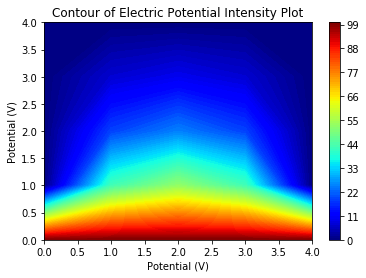

In [3]:
'''Input the no. of col & rows for square matrix, "v" created grid empty grid
    (N by N matrix), filled the matrix with guess and "new_v" created for
    future use in the "jacobi" and "j_iteration" functions'''
N = 5    # CHANGE THIS TO 4, 10, 15, 30, 50
v = np.zeros(shape=(N, N))
guess = 50
v.fill(guess)
new_v = np.zeros(shape=(N, N))

def boundary(v, x, y, b_top, b_bottom, b_left, b_right):
    '''The boundary condition function setting the walls of the matrix/grid'''
    for i in range(x):
        for j in range(y):
            if i == 0:
                v[i][j] = b_top
            elif i == x-1:
                v[i][j] = b_bottom
            elif j == 0:
                v[i][j] = b_left
            elif j == y-1:
                v[i][j] = b_right
    return v

def jacobi(x, y, b_top, b_bottom, b_left, b_right, h):
    '''Jacobbi function defined using two "for" loops in range 1 to x/y -1
    because 0 & x/y would effect/change the boundaries. The equation produces a
    new potential (new_v) '''
    for i in range(1, x-1, h):
        for j in range(1, y-1, h):
            new_v[i, j] = 0.25 * (v[i-1, j] + v[i+1, j] + v[i, j-1] + v[i, j+1])
    return boundary(new_v, N, N, 100, 0, 0, 0)


def j_iteration(x, y, b_top, b_bottom, b_left, b_right, h):
    '''function for the iteration with a set tolerance of 1e-12 using the
    "numpy all.close" function, "global" used to store "v" as a  local variable
    of the function. "no_iteration" is the number of iterartions in a "for"
    loop in a large range then calling "jacobi". Next an "if" statement used
    for statement to print the number of iterations required to converge to the
    tolerance stated in the "np.allclose" ~ e-12 breaking the loop or "else"
    statement repeats until "if" statement met'''
    global v
    print("initial matrix\n",boundary(v, x, y, b_top, b_bottom, b_left, b_right) , "\n")
    jacobi(x, y, b_top, b_bottom, b_left, b_right, h)

    no_iteration = 0
    for no_iteration in range (0, 10000):
        jacobi(N, N, b_top, b_bottom, b_left, b_right, h)
        if np.allclose(v, new_v, atol = 1e-12, rtol = 0):# atol nearly always outweighs ryol
            print("Converged at tolerance of 1e-12 after" , no_iteration , " iterations.")
            print("The last, relaxed potential matrix is:\n", v)
            break
        else:
            v = np.matrix.copy(new_v)
            
def plot():
    '''The plot function the X and Y axis is created using "numpy arange"
    returning coordinate vectors from coordinate matrices mapping intensities.'''
    h = 1
    X, Y = np.meshgrid(np.arange(0, N, h), np.arange(0, N, h))
    colorinterpolation = 100
    colourMap = plt.cm.jet

    plt.title("Contour of Electric Potential Intensity Plot")
    plt.contourf(X, Y, v, colorinterpolation, cmap=colourMap)
    plt.ylabel('Potential (V)')
    plt.xlabel('Potential (V)')
    plt.colorbar()
    plt.show()
    

j_iteration(N, N, 100, 0, 0, 0, 1)    
plot()

**Design** PEP8 (Python Enhancement Proposal) style of coding used to improve readability and reduce errors. 

**Jacobbi** method calculates each node based on the previous values for each of the neighbouring nodes.

**Code**
I have chosen the Jacobi method defining four functions:
1. **boundary** This defines the boundary conditions using "if" and "elif" statements, returning a the matrix/grid "v".
2. **jacobi** Using "for" loops in a range to not change the boundary conditions, the 2D grid this gives the points within the grid applying the basic equation (where \rho = 0).
3. **j_iteration**  A "for" loop used for the number of iterartions  (true when absolute(v - new_v) <= (atol + rtol * absolute(new_v))).
4. **plot** Arrays for vectorized evaluations of N by N scalar fields over N by N grid, given 1D coordinate arrays x1, x2,..., xn... and y1, y2,..., yn,... using "colourmap" the intensity of the different potentails was visually displayed using colours/colour bar.

derivattive equations defined
Grid of nodes defined
Boundaries set on nodes
Establish finite difference functions (Taylor)
Define grid of nodes (what variables are you differentiating wrt:
that’s the space you need to define them for)'''

 Define FDM equations
 Define grid of nodes in x-y space, separated by h (1)
 Fix values of nodes on outside points of grid to BC values
 Set nodes inside to guess (do this before BCs)
 Repeatedly apply the FDM function to the non-bc nodes
 Each time you apply the FDM, compute a new value for every node
 Once you have every node, make a copy of this NEW grid
 Repeat the FDM on each value on NEW grid node then make a NEW NEW grid
 Repeat iterations until you get convergence within a certain tolerance
 

# atol/rtol
Returns True if two arrays are element-wise equal within a tolerance.
The tolerance values are positive, typically very small numbers. The relative difference (rtol * abs(b)) and the absolute difference atol are added together to compare against the absolute difference between a and b.
If either array contains one or more NaNs, False is returned. Infs are treated as equal if they are in the same place and of the same sign in both arrays.

Parameters:
a, b : array_like
Input arrays to compare.
rtol : float
The relative tolerance parameter (see Notes).
atol : float
The absolute tolerance parameter (see Notes).



Verify your function by checking it works in a simple, known case. Compare the solution found with the analytical solution and quantify the differences. Use this to investigate the sensitivity of your solution to the choice of grid density and convergence condition.

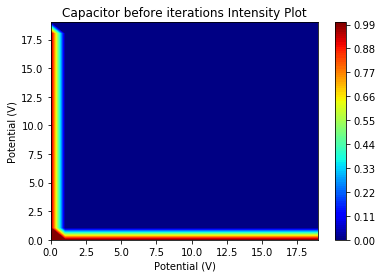

initial matrix
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

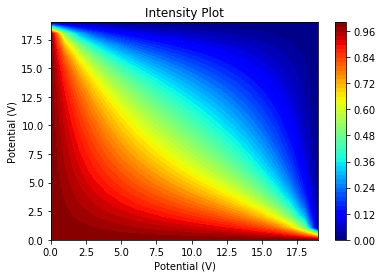

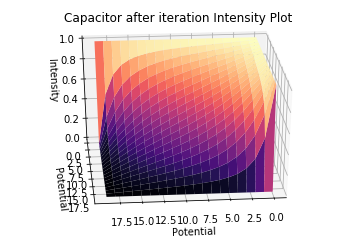

'PLEASE WAIT FOR ALL 3 GRAPHS TOO LOAD'

In [20]:
#plot the differences
'''All you need is to set up a problem to solve computationally,
and then compare that with the analytical solution

The easiest thing I can think of, is to set up a region
(say a square region) where the edges have a constant potential,
and then the solution to the Laplace equation for that is that
every point within the region is exactly the same as the boundary potential

Look in the Griffiths Electrodynamics textbook if you need to know why
that is the analytical solution to that problem
set boundaries all to 10 because laplace they should eventually average to laplace
'''

'''Input the no. of col & rows for square matrix, "v" created grid empty grid
    (N by N matrix), filled the matrix with guess and "new_v" created for
    future use in the "jacobi" and "j_iteration" functions'''
N = 20
v = np.empty(shape=(N, N))
guess = 0
v.fill(guess)
new_v = np.empty(shape=(N, N))

def jacobi(x, y, b_top, b_bottom, b_left, b_right, h, plate, BC):
    '''Jacobbi function defined using two "for" loops in range 1 to x/y -1
    because 0 & x/y would effect/change the boundaries. The equation produces a
    new potential (new_v) '''
    for i in range(1, x-1, h):
        for j in range(1, y-1, h):
            new_v[i, j] = 0.25 * (v[i-1, j] + v[i+1, j] + v[i, j-1] + v[i, j+1])
            if BC == boundary:
                boundary(new_v, N, N, 1, 0, 1, 0)
            if BC == cap:
                cap(plate, v)
    x = np.arange(0,N,1)
    y = np.arange(0,N,1)
    return x,y,new_v
'''This plots the graph before diffusion occurs(shows boundaries)'''
x,y,new_v = jacobi(N, N, 1, 0,1, 0, 1,1000,boundary)

colorinterpolation = 100
colourMap = plt.cm.jet

plt.title("Capacitor before iterations Intensity Plot")
plt.contourf(x, y, new_v, colorinterpolation, cmap=colourMap)
plt.ylabel('Potential (V)')
plt.xlabel('Potential (V)')
plt.colorbar()
plt.show()


def j_iteration(x, y, b_top, b_bottom, b_left, b_right, h):
    global v
    print("initial matrix\n",boundary(v, x, y, b_top, b_bottom, b_left, b_right) , "\n")
    jacobi(x, y, b_top, b_bottom, b_left, b_right, h,1000,boundary)

    no_iteration = 0
    for no_iteration in range (0, 1000):
        jacobi(N, N, b_top, b_bottom, b_left, b_right, h,1000,boundary)
        if np.allclose(v, new_v, atol = 1e-4, rtol = 0):# atol nearly always outweighs rtol
            print("Converged at tolerance of 1e-4 after" , no_iteration , " iterations.")
            print("The last, relaxed potential matrix is:\n", v)
            break
        else:
            v = np.matrix.copy(new_v)
            
j_iteration(N, N, 1, 0, 1, 0, 1)
print(v)

def plot():
    '''The plot function the X and Y axis is created using "numpy arange"
    returning coordinate vectors from coordinate matrices mapping intensities.'''
    h = 1
    X, Y = np.meshgrid(np.arange(0, N, h), np.arange(0, N, h))
    colorinterpolation = 50
    colourMap = plt.cm.jet

    plt.title("Intensity Plot")
    plt.contourf(X, Y, v, colorinterpolation, cmap=colourMap)

    plt.ylabel('Potential (V)')
    plt.xlabel('Potential (V)')
    plt.colorbar()
    plt.show()
    '''This next plot is 3D graph showing intensity in terms of the z axis'''
    h = 1
    X, Y= np.meshgrid(np.arange(0, N, h), np.arange(0, N, h))#1d arrays

    Z = v #2d array
    
    ax = plt.axes(projection='3d')
    plt.title("Capacitor after iteration Intensity Plot")
    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,cmap='magma')

    ax.view_init(30, 85)#change
    ax.set_xlabel('Potential')
    ax.set_ylabel('Potential')
    ax.set_zlabel('Intensity')
    plt.show() 
plot()
'''PLEASE WAIT FOR ALL 3 GRAPHS TOO LOAD'''

It is clear that although the numerical solution is qualitatively similar to the analytical solution, there are signiﬁcant quantitative differences. The bottom and left are set to 1 and the other points to zero you expect a y=-x line from 1 to 1 and the bottom lower left side of that line to approach 1 as seen.

Another solution is to set the sides all to 1 and the middle to zero as infinite time is approached the whole square approached the same value (1).

## 1b)
Now use your function to calculate the potential and electric field within and around a parallel plate capacitor comprising a pair of plates of length a, separation d. Demonstrate that the field configuration approaches the “infinite” plate solution (E = V/d between plates, E = 0 elsewhere) as the ratio of  becomes large.

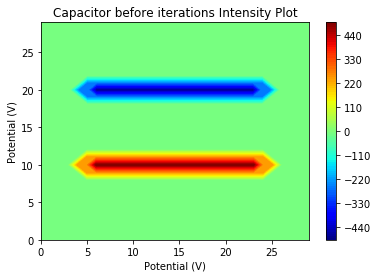

initial matrix
 [[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0. 

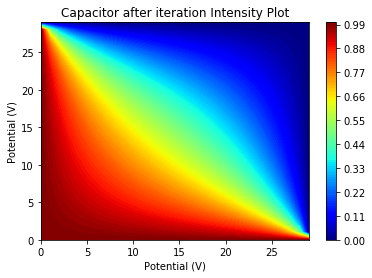

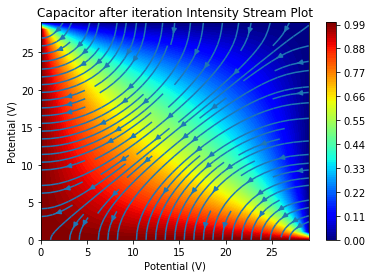

'PLEASE WAIT FOR 4 GRAPHS'

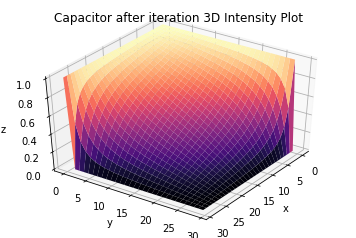

In [21]:
N = 30
v = np.zeros(shape=(N, N))
guess = 0
v.fill(guess)
new_v = np.zeros(shape=(N, N))

################################################################################################

def cap(plate, v):
    v[20, 5:25] = - plate
    v[10, 5:25] = plate
    return plate, v

##################################################################################################
'''First plot shows intial conditions'''
x,y,new_v = jacobi(N, N, 0, 0, 0, 0, 1,1000,cap)

colorinterpolation = 100
colourMap = plt.cm.jet

plt.title("Capacitor before iterations Intensity Plot")
plt.contourf(x, y, new_v, colorinterpolation, cmap=colourMap)
plt.ylabel('Potential (V)')
plt.xlabel('Potential (V)')
plt.colorbar()
plt.show()
            
j_iteration(N, N, 0, 0, 0, 0, 1)

def plot():
    '''The plot function the X and Y axis is created using "numpy arange"
    returning coordinate vectors from coordinate matrices mapping intensities.'''
    h = 1
    X, Y = np.meshgrid(np.arange(0, N, h), np.arange(0, N, h))
    colorinterpolation = 100
    colourMap = plt.cm.jet

    plt.title("Capacitor after iteration Intensity Plot")
    plt.contourf(X, Y, v, colorinterpolation, cmap=colourMap)
    plt.ylabel('Potential (V)')
    plt.xlabel('Potential (V)')
    plt.colorbar()
    plt.show()
    
    X, Y = np.meshgrid(np.arange(0, N, h), np.arange(0, N, h))
    colorinterpolation = 100
    colourMap = plt.cm.jet
    V, U = np.gradient(v)

    plt.streamplot(X, Y, U, V)
    plt.title("Capacitor after iteration Intensity Stream Plot")
    plt.contourf(X, Y, v, colorinterpolation, cmap=colourMap)
    plt.ylabel('Potential (V)')
    plt.xlabel('Potential (V)')
    plt.colorbar()
    plt.show()
    
    h = 1
    X, Y= np.meshgrid(np.arange(0, N, h), np.arange(0, N, h))#1d arrays

    Z = v #2d array
    
    ax = plt.axes(projection='3d')
    plt.title("Capacitor after iteration 3D Intensity Plot")
    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,cmap='magma')

    ax.view_init(40, 35)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z') 
      
plot()

'''PLEASE WAIT FOR 4 GRAPHS'''

4 plots above to show different representations of the capacitor. Larger plate voltages and larger matrix boundaries observed the best results. it is imperative that h is a integer (1) or float point error occurs. Decreasing the number of interations reduces the range of the potentail making it look closer to the initial condition as expected. increasing(towards 1)he value of atol rapidly increases the run time with little effect on the accuracy of the graphs. increasing atol means more iterations required for the same garphs however this is much faster.

# Q2 - The Diffusion Equation

Solving the diffusion equation 

$$\alpha \nabla^2 \phi = \frac{\partial \phi}{\partial t}$$

is mathematically similar to solving the Poisson equation. The technique will be to start from known initial conditions and use finite difference equations to propagate the node values forwards in time (subject to any boundary conditions).

A first try using Equation 1 above gives the finite difference form:

$$\frac{\phi′(x_i) − \phi(x_i)}{\delta t} = \frac{\alpha}{h^2} [\phi (x_{i−1}) + \phi(x_{i+1}) − 2\phi(x_i)]$$

Here the values, $\phi$, at three neighbouring points at a time t are used to evaluate the value $\phi`$ at the next time step, $t + \delta t$. This is known as a forward-time or explicit method. Unfortunately, this methood is known to be unstable for certain choices of $h$ and $\delta t$.

A stable alternative is obtained by using the equivalent backward-time or implicit equation:

$$\frac{\phi'(x_i) - \phi(x_i)}{\delta t} = \frac{\alpha}{h^2} [\phi'(x_{i-1}) + \phi'(x_{i+1}) -  2\phi'(x_i)] $$

Now the spatial derivative on the right-hand side needs to be evaluated at $t + \delta t$, which may appear problematic as the $\phi(x)$ values are known while the updated $\phi′(x)$ values are not. Fortunately Equation 3 can be written explicitly in matrix form and solved using the methods explored in Assignment 1.


## 2a)
An iron poker of length 50 cm is initially at a temperature of 20 C. At time t = 0, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Ignoring heat losses along the length of the poker, calculate the temperature distribution along it as a function of time. You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K and its density as 7,900 kg/m3.

Your solution should apply the implicit finite difference method above. It is also recommended that you use an appropriate linear algebra routine from numpy/scipy. You should find ways to verify your results, and quantify the uncertainties due to the method. Discuss your results in the text box below.

<function forward_euler at 0x0000023E0DFB68C8> TIME TAKEN FOR EACH LINE ON THE PLOTS
0.015522956848144531 seconds
0.11167097091674805 seconds
0.728600263595581 seconds
7.777524471282959 seconds
90.91707491874695 seconds


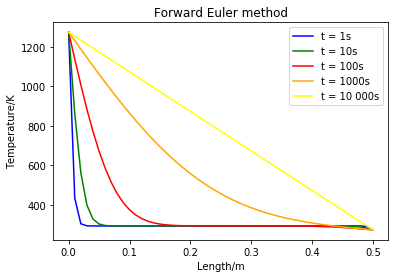

<function backwards_euler at 0x0000023E0DFB6F28> TIME TAKEN FOR EACH LINE ON THE PLOTS
0.0 seconds
0.0 seconds
0.0040018558502197266 seconds
0.004325151443481445 seconds
0.0 seconds


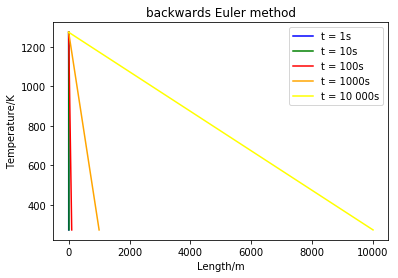

<function tridiagonal_backward_euler at 0x0000023E0DFB66A8> TIME TAKEN FOR EACH LINE ON THE PLOTS
0.016205310821533203 seconds
0.13713693618774414 seconds
1.2654459476470947 seconds
15.414170026779175 seconds
153.3314917087555 seconds


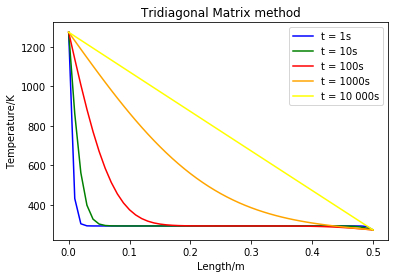

'PLEASE WAIT FOR ALL 3 GRAPHS TO LOAD, thank you'

In [17]:
def constant(thermal_conductivity, density, specific_heat):
    #UNITS USED THEREFORE TEMPERATURE MUST BE IN KELVIN
    # thermal conductivity in W/m/K
    # density in kg/m3
    # heat capacity in J/kg/K
    alpha = thermal_conductivity /(density * specific_heat)    
    return alpha #1.7e-5

def intial_condition(L,dx,T,dt,final_temp):
    '''creates a rod of length L and sets the initial conditions '''
    alpha = constant(59,7900,450)
    
    #displacement set
    rod = np.arange(0, L + dx, dx)#start,stop ,Spacing between values(step)
    Nx = len(rod)                 #tells you the length of the array
    
    #time set
    time_condition = np.arange(0, T + dt, dt)
    Nt = len(time_condition)
    
    F = (alpha*dt)/(dx**2)      #divergence, gradient (this value will effect the efficency and speed of the methods)
    
    phi_initial = np.zeros(Nx)  #fills with zeroes
    
    phi_initial.fill(293)       #20 degrees (rod temperature)
    phi_initial[0] = 1273       #1000 degrees furnace
    phi_initial[Nx - 1] = final_temp   #zero degrees or 20 degrees
    phi_new = np.copy(phi_initial)
    
    return rod, Nx, time_condition, Nt, F, phi_initial, phi_new

def forward_euler(L,dx,T,dt,final_temp):
    #timer used to measure the CPU time for each method 
    start_time = time.time()
    
    rod, Nx, time_condition, Nt, F, phi_initial, phi_new = intial_condition(L,dx,T,dt,final_temp)
    for j in range(0, Nt):
        # the inner mesh points computed for phi
        for i in range(1, Nx - 1):
            phi_new[i] = phi_initial[i] + F*(phi_initial[i-1] + phi_initial[i+1] - 2*phi_initial[i])
                    #before  the next step phi_new updated 
        phi_initial[:] = phi_new # through all elements
        
    end_time = time.time()
    total_time_fe =  end_time-start_time #CPU time recorded
    
    print(total_time_fe,'seconds')
    
    return rod, phi_new


def backwards_euler(L, T, dx, dt, final_temp):
    
    start_time = time.time()

    rod, Nx, time_condition, Nt, F, phi_initial, phi_new = intial_condition(L,dx,T,dt,final_temp)

    # linear system created filling 2 matrices with zeros
    A = np.zeros((Nx, Nx))
    b = np.zeros(Nx)
    
    #updating A
    for i in range(1, Nx-1):
        
        A[i, i - 1] = -F; A[i, i + 1] = -F
        A[i, i] = 1 + 2*F
        
    A[0, 0] = A[Nx - 1, Nx - 1] = 1

    for n in range(0, Nt):
        for i in range(1, Nx):

            b[i] = phi_initial[i]
            b[0] = 1273
                
        phi_new[:] = scipy.linalg.solve(A, b)
        phi_initial[:] = phi_new

    end_time = time.time()
    total_time_be =  end_time - start_time
    
    print(total_time_be,'seconds')

    return rod, phi_new

def tridiagonal_backward_euler(L,dx,T,dt,final_temp):
    
    start_time = time.time()
    
    rod, Nx, time_condition, Nt, F, phi_initial, phi_new = intial_condition(L,dx,T,dt,final_temp)
    
    # the sparse matrix and right-hand side
    diagonal = np.zeros(Nx)
    lower = np.zeros(Nx-1)
    upper = np.zeros(Nx-1)
    
    b = np.zeros(Nx)
    
    #sparse matrix (see below for eq) pre computing
    diagonal[:] = 1 + 2*F
    lower[:] = -F; upper[:] = -F
    
    #the boundary conditions of matrix
    diagonal[0] = 1
    upper[0] = 0
    diagonal[Nx-1] = 1
    lower[-1] = 0

    A = scipy.sparse.diags(diagonals=[diagonal, lower, upper],offsets=[0, -1, 1], shape=(Nx, Nx),format='csr')

    phi_initial[0] = 1273

    for n in range(0, Nt):
        
        b = phi_initial
        b[Nx - 1] = 273
        phi_new[:] = spsolve(A, b)

        phi_initial, phi_new = phi_new, phi_initial
        
    end_time = time.time()
    total_time_tbe = end_time - start_time
    
    print(total_time_tbe,'seconds')    
    
    return rod, phi_new

def Plot(graph):
    #plotting all 3 methods for a range of times
    print(graph,"TIME TAKEN FOR EACH LINE ON THE PLOTS")
    rod, phi_new = graph(0.5, 0.01, 1, 0.01,273)#function(L,dx,T,dt,final_temp)
    plt.plot(rod, phi_new, color='blue', label="t = 1s")
    
    rod, phi_new = graph(0.5, 0.01, 10, 0.01,273)
    plt.plot(rod, phi_new, color='green', label="t = 10s")
    
    rod, phi_new = graph(0.5, 0.01, 100, 0.01,273)
    plt.plot(rod, phi_new, color='red', label="t = 100s")
    
    rod, phi_new = graph(0.5, 0.01, 1000, 0.01,273)
    plt.plot(rod, phi_new, color='orange', label="t = 1000s")

    rod, phi_new = graph(0.5, 0.01, 10000, 0.01,273)
    plt.plot(rod, phi_new, color='yellow', label="t = 10 000s")
    
    plt.xlabel('Length/m')
    plt.ylabel('Temperature/K')
    plt.legend()
    plt.show()

plt.title("Forward Euler method")
Plot(forward_euler)

plt.title("backwards Euler method")
Plot(backwards_euler)

plt.title("Tridiagonal Matrix method")
Plot(tridiagonal_backward_euler)

'''PLEASE WAIT FOR ALL 3 GRAPHS TO LOAD, thank you'''

Using equation below:

**$$\rho C_p \frac{\partial T}{\partial t} = Q +\nabla \cdot (k \nabla T)$$**
  
 $\rho$ density, $C_p$ heat capacity, $T$ Temperaure, $t$ Time, $Q$ heat added, $k$ thermal conductivity
 
 from 
 $$\alpha \nabla^2 \phi = \frac{\partial \phi}{\partial t}$$
 
The diffusion equation converges as time approaches infinity to a stationary solution for Temperature at this limit both first derivative of temperature with respect to time and second derivative of temperature with respect to position are zero this is called Laplace's equation.

the 3 methods chosen to solve this task were:

1. Forward Euler(explicit method) - applying a simple formula to the values of an unknown function at each of the spatial mesh points at a new time. where each mesh point has a closed-form formula for unknowns(i.e It is a coupled system using previous the equations to obtain unknown functions at new times). The limiting factor for the Foward Euler method is that depends on F (dimensionless number that combines (constants) alpha and the discretization parameters dt and dx into one single parameter.) where the time step size has the greatest effect on F.If $F>1/2$ then growing solutions observed.

2. Backward Euler(implicit method)- The matrix A (see below) contains values that do not change with time. So, matrix A can be created once (and for all) before the recursive formulas are entered for the evoluting time. The matrix b (on the right-hand side of the equatiopn) however, must be updated at each new time step. The Backward Euler(implicit method) requires the solution of coupled equations (the matrix system for each new time interval).This method can take much larger stable timesteps than the Foward Euler method. However too large timesteps can cause less accurate solutions therefore a balance between accuracey and stability must be found.

$$A U = b $$

$$\begin{pmatrix}1+2F & -F\\-F & 1+2F\end{pmatrix} \begin{pmatrix}u_1^n\\ u_2^n\end{pmatrix} = \begin{pmatrix}u_1^{n-1}\\_2^{n-1}\end{pmatrix}$$

The backward Euler method has only local truncation error (defined as the error produced in 1 iteration) $O(h^{2}) $ becuase it is only first order therfore having a big O of $O(h)$ error at any specfic time.Therefore a region of absolute stability in the complex plane of the circle of radius 1 centered at (1,0) on the axis.


3. Sparse matrix implementation (tridiagonal matrix backwards)-Now matrix A is made tri-diagonal storing values (majority are zero). The algorithm uses the fact of the matrix's special property(being tri diagonal) This allows this method to work far faster than the previous two especially for large values of Nx. Utilizing the scipy.sparse.linalg.spsolve package solves using Guassian elimination with great effiecency. The code only stores the upper,lower and main diagonal values of the matrix the rest are zero. 


Fastest was Tridiagonal backwards ,then Forward Euler and slowest being Backwards Euler.

Changing the value of dx: decreasing dx saw huge run time increases and very little difference in the graphs. As dx approaches L all the gradients on all the graphs converge to the same straight line linear negative gradient.


Changing the value of dt: increasing dt to larger values causes the smoothness of the curves to decrease and therefore becoming less accurate (usually dt = 0.1 onwards). Decreasing dt saw large increase in run times as expected 

## 2b)
Now repeat the calculation, but assume the far end of the poker from the furnace is no longer held at 0 C, and experiences no heat loss. You will need to modify your code to achieve this, and you should discuss the motivation for your changes below.

<function forward_euler at 0x0000023E0DFB6F28> TIME TAKEN FOR EACH LINE ON THE PLOTS
0.015616178512573242 seconds
0.0954291820526123 seconds
0.9041416645050049 seconds
8.388132810592651 seconds


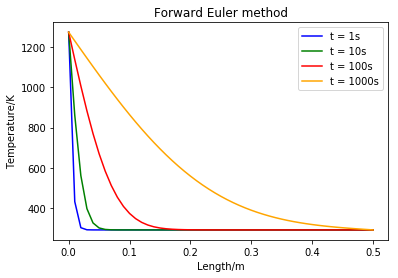

<function backwards_euler at 0x0000023E0DFB66A8> TIME TAKEN FOR EACH LINE ON THE PLOTS
0.0 seconds
0.0 seconds
0.0 seconds
0.0 seconds


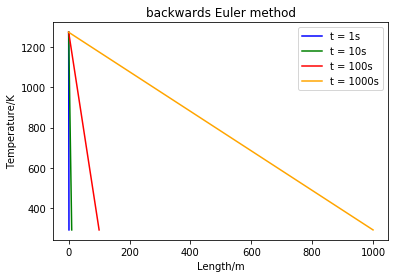

<function tridiagonal_backward_euler at 0x0000023E090C1158> TIME TAKEN FOR EACH LINE ON THE PLOTS
0.015764713287353516 seconds
0.12566471099853516 seconds
1.1891942024230957 seconds
11.70007848739624 seconds


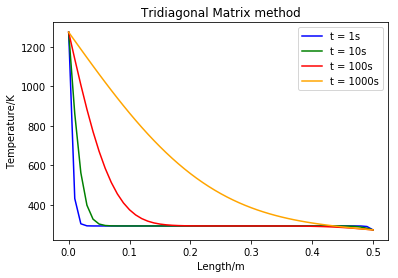

In [14]:
def Plot(graph):
    #the final temperature has now changed since there is no heat loss
    print(graph,"TIME TAKEN FOR EACH LINE ON THE PLOTS")
    rod, phi_new = graph(0.5, 0.01, 1, 0.01,293)#function(L,dx,T,dt,final_temp)
    plt.plot(rod, phi_new, color='blue', label="t = 1s")
    
    rod, phi_new = graph(0.5, 0.01, 10, 0.01,293)
    plt.plot(rod, phi_new, color='green', label="t = 10s")
    
    rod, phi_new = graph(0.5, 0.01, 100, 0.01,293)
    plt.plot(rod, phi_new, color='red', label="t = 100s")
    
    rod, phi_new = graph(0.5, 0.01, 1000, 0.01,293)
    plt.plot(rod, phi_new, color='orange', label="t = 1000s")

    rod, phi_new = graph(0.5, 0.01, 10000, 0.01,273)
    plt.plot(rod, phi_new, color='yellow', label="t = 10 000s")
    
    plt.xlabel('Length/m')
    plt.ylabel('Temperature/K')
    plt.legend()
    plt.show()

plt.title("Forward Euler method")
Plot(forward_euler)

plt.title("Backwards Euler method")
Plot(backwards_euler)

plt.title("Tridiagonal Matrix method")
Plot(tridiagonal_backward_euler)

**Since there is no heat loss and the side at 0.5m is no longer held at 273k the graphs reach a gradients... and tend to smoothen out faster. Therefore this change increases the rate of diffusion observed. Originally the right hand side boundary would reset to 273k after each iteration but this is no longer required and fractionally decreases the CPU time.**

## Extensions

There are many possible extensions to this assignment, for example :
* Model the field in more complex arrangements than the parallel plate capacitor in 1b).
* Model a point charge using the code from Q1? What are the problems/challenges in doing so ?
* Demonstrate that the explicit method in Q2 is unstable for some choices of $\delta t$ and $h$.
* Implement higher-order methods (eg. Crank-Nicolson which includes a 2nd order difference for the spaital derivative).

You are advised to discuss any extensions with your demonstrator or the unit director.  If you wish to include any extensions, please do so *below* this cell.

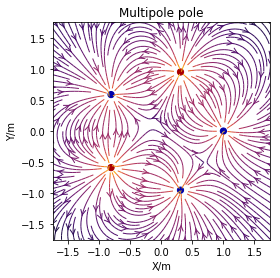

In [16]:
'''I created a multipole around a circle changing the value of nq will change the number of poles'''
def Electric_field(Q, r0, x, y):
    #Return the electric field vector E=(Ex,Ey) due to charge Q at radius r0
    denominator = np.hypot(x-r0[0], y-r0[1])**3
    q1=Q * (x - r0[0]) / denominator
    q2=Q * (y - r0[1]) / denominator
    return q1,q2

# creating grid of x and y points in a mesh
nx, ny = 64, 64
x ,y = np.linspace(-2, 2, ny),np.linspace(-2, 2, nx)
X, Y = np.meshgrid(x, y)

# multipole where nq is the number of charges which alternate signs as you change nq

##############################################################################
nq = 5 #number of charges CHANGE YOURSELF! I RECOMMEND 1,2,6,12
#############################################################################

charges = []#empty array created

for i in range(nq):
    Q = i%2 * 2 - 1
    charges.append((Q, (np.cos(2*np.pi*i/nq), np.sin(2*np.pi*i/nq))))

# Electric field vector in terms of separate x and y components of the electric field as E=(Ex, Ey)
Ex, Ey = np.zeros((ny, nx)), np.zeros((ny, nx))
for charge in charges:
    ex, ey = Electric_field(*charge, x=X, y=Y)
    Ex += ex;    Ey += ey


fig = plt.figure()
ax = fig.add_subplot(111)

# plotting the streamlines with a colormap
color = 2 * np.log(np.hypot(Ex, Ey))
ax.streamplot(x, y, Ex, Ey, color=color, linewidth=1, cmap=plt.cm.inferno,density=2, arrowstyle='->', arrowsize=1.25)

# Add filled circles for the charges themselves, alternating their charges
charge_colors = {True: '#aa0000', False: '#0000aa'}
for Q, pos in charges:
    ax.add_artist(Circle(pos, 0.05, color=charge_colors[Q>0]))#changes the poles into red for positive or blue for negative

ax.set_xlabel('X/m')
ax.set_ylabel('Y/m')
ax.set_xlim(-1.75,1.75)
ax.set_ylim(-1.75,1.75)
ax.set_title('Multipole pole')
ax.set_aspect('equal')
plt.show()

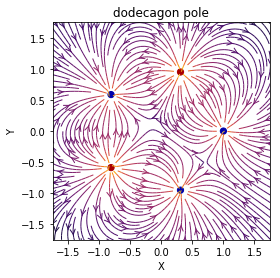

In [27]:
'''Here my code creates multipoles around a circle and for each new pole is opposite in charge compared to the last'''